In [24]:
import numpy as np
import matplotlib.pyplot as plt
from database_methods import Table, to_show, head
from global_var import *
import sqlite3
con = sqlite3.connect('database_results.db')
cursor = con.cursor()

In [25]:
def spr_spectrum(folder, what = 'q'):
    main_folder='C:/SPRUP_data_Jenda/2019_03_13_Jenda_microscopy/'
    with open(main_folder + folder+'spectra_{}.txt'.format(what)) as f:
        infolist = f.read()
        info = []
    for i in infolist.split('\n')[:-1]:
        info.append([float(j) for j in i.split('\t')])
    intensity = [] 
    wlength = []
    for row in info:
        wlength.append(row[4])
        intensity.append(row[5])
    return wlength, intensity

def load_sql(sql_data, columns):
    col = columns.split(', ')

    data = dict()
    for c in col:
        data[c] = []

    for row in sql_data:
        i = 0
        for r in row:
            data[col[i]].append(r)
            i+=1
    return data

def add_spr(axesspr, name):
    wlength, intensity = spr_spectrum(name)
    wlength_pbs, intensity_pbs = spr_spectrum(name, 'pbs')
    axessen = axesspr.twinx()
    
    if len(intensity) > len(intensity_pbs): length = len(intensity_pbs)
    else: length = len(intensity)
        
    sensitivity = [(intensity[i] - intensity_pbs[i])/0.005 for i in range(length )]
    
    for tick in axesspr.get_yticklines():
        tick.set_visible(False)

    for tick in axesspr.get_yticklabels():
        tick.set_visible(False)
        
    for tick in axessen.get_yticklines():
        tick.set_visible(False)

    for tick in axessen.get_yticklabels():
        tick.set_visible(False)
        
    axessen.plot(wlength, intensity, linewidth=2, color=gray, label='spectrum', ls = ':')  
    
    axesspr.plot(wlength_pbs, sensitivity, color=red, label='sensitivity', ls = ':')  
    
def data_about_master(master):
    columns = 'WAVELENGTH, CON, INP, IBGPX, INPPX, RATE, COUNT'
    sql_data = con.execute("""
    SELECT {}
    FROM 'masters' as MAS 
    INNER JOIN 'experiments' as EXP 
    ON MAS.ID = EXP.MASTER_ID
    INNER JOIN 'measurements' as MEAS
    ON EXP.ID = MEAS.EXPERIMENT_ID
    WHERE MASTER = '{}' AND EXP_TYPE='-' AND NP=80
    ORDER BY WAVELENGTH ASC
    ;
       """.format(columns, master))
    
    sql_folder = con.execute("""
    SELECT FOLDER
    FROM 'masters' as MAS 
    INNER JOIN 'experiments' as EXP 
    ON MAS.ID = EXP.MASTER_ID
    WHERE MASTER = '{}';
       """.format(master))
    
    return load_sql(sql_data, columns), [s[0] for s in sql_folder][0]

def plot_spectrum(data, folder):
    fig, axes = plt.subplots()  
    axes.set_title('CONTRAST')
    axes.set_xlabel('$\lambda$ [nm]')
    axes.set_ylabel('R')
    axessen = axes.twinx()
    axessen.set_ylabel('Sensitivity [RIU$^{-1}$]')
    axes.grid(linestyle='--')
    
    wlength, intensity = spr_spectrum(folder)
    wlength_pbs, intensity_pbs = spr_spectrum(folder, 'pbs')
    
    if len(intensity) > len(intensity_pbs): length = len(intensity_pbs)
    else: length = len(intensity)
        
    sensitivity = [(intensity[i] - intensity_pbs[i])/0.005 for i in range(length )]
    
        
    axes.plot(wlength, intensity, linewidth=2, color=gray, label='spectrum')  
    axessen.plot(wlength_pbs, sensitivity, color=red, label='sensitivity') 
    
    fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
def plot_contrast(data, folder):
    fig, axes = plt.subplots()  
    axes.set_title('CONTRAST')
    axes.set_xlabel('$\lambda$ [nm]')
    axes.set_ylabel('bg intensity [a.u.]')

    axes_ii=axes.twinx()
    axes.grid(linestyle='--', axis = 'x')
    axes_ii.set_ylabel('NP contrast [a.u.]')
    axes_ii.grid(linestyle='--', axis = 'y')
    
    axes_ii.plot(data['WAVELENGTH'], data['CON'], linewidth=2, color=red, label='contrast') 
    axes_ii.set_ylim(0, max( data['CON'])*1.1)
    axes.plot(data['WAVELENGTH'], data['IBGPX'], linewidth=2, color=black, label='intensity of background')

    add_spr(axes.twinx(), folder)
    fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
def plot_npi(data, folder):
    fig, axes = plt.subplots()
    axes.set_title('NP intensity')
    axes.set_xlabel('$\lambda$ [nm]')
    axes.set_ylabel('NP intensity per')
    axes_ii=axes.twinx()
    axes.grid(linestyle='--', axis = 'x')
    axes_ii.set_ylabel('NP intensity per px[a.u.]')
                 
    axes_ii.grid(linestyle='--', axis = 'y')

    axes_ii.plot(data['WAVELENGTH'], data['INP'], linewidth=2, color=yellow, label='intensity of NP per px')
    axes_ii.set_ylim(0, max( data['INP'])*1.1)
    axes.plot(data['WAVELENGTH'], data['INPPX'], linewidth=2, color=blue, label='intensity of NP')
    axes.set_ylim(0, max( data['INPPX'])*1.1)
    
    add_spr(axes.twinx(), folder)
    fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
def plot_rate(data, folder):
    fig, axes = plt.subplots()
    axes.set_title('NP binding rate & count')
    axes.set_xlabel('$\lambda$ [nm]')
    axes.set_ylabel('total count')
    axes_ii=axes.twinx()

    
    axes.grid(linestyle='--', axis = 'x')    
    axes_ii.set_ylabel('binding rate [#/100f]')
                 
    axes_ii.grid(linestyle='--', axis = 'y')

    axes_ii.plot(data['WAVELENGTH'], data['RATE'], linewidth=2, color=green, label='rate')    
    axes.plot(data['WAVELENGTH'], data['COUNT'], linewidth=2, color=purple, label='count')
    axes_ii.set_ylim(0, max( data['RATE'])*1.1)
    axes.set_ylim(0, max( data['COUNT'])*1.1)
    
    add_spr(axes.twinx(), folder)
    fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [26]:
mas = Table(connection=con, name='masters')
exp = Table(con, name = 'experiments')
meas = Table(con, name = 'measurements')

In [27]:
print(mas.columns)
print(exp.columns)
print(meas.columns)

CATEGORY, PERIOD, AMPLITUDE, MASTER, FWHM, R, S
DATE, MASTER_ID, DIP, FOLDER
EXPERIMENT_ID, NP, WAVELENGTH, FILE, AR_TH, AR_DIP, AR_NOISE, EXC_THS, RATE, INFO, COUNT, X, Y, CON, INP, INPPX, IBGPX, STD, stdX, stdY, stdCON, stdINP, stdINPPX, stdIBGPX, stdSTD, NOTES, AR_MIN, AR_COND, EXP_TYPE


In [28]:
# 
columns = ' MASTER, COUNT(MASTER), S, R, AVG(CON), AVG(INP), AVG(INPPX), AVG(IBGPX)'
data = con.execute("""
SELECT {}
FROM 'masters' as MAS 
INNER JOIN 'experiments' as EXP 
ON MAS.ID = EXP.MASTER_ID
INNER JOIN 'measurements' as MEAS
ON EXP.ID = MEAS.EXPERIMENT_ID
WHERE EXP_TYPE='-' AND NP = '80' AND (NOTES = 'nice' OR NOTES ='-')
GROUP BY MASTER
ORDER BY CATEGORY DESC
;
   """.format(columns))

head('MASTER, COUNT, S_BULK, R(DIP), CONTRAST, INT_NP, INP/PX, INT_BG')

i=0
for row in data:
    if i%2 == 0:
        print('-'*60)
    print(str(to_show(row)).replace(', ', '\t').replace("'", "")[1:-1])

    i+=1
    
    
print('---\n{}'.format(i))

MASTER	COUNT	S_BULK	R(DIP)	CONTRAS	INT_NP	INP/PX	INT_BG
------------------------------------------------------------
Q4	6	30.70	22.00	3.86	26.87	1.74	0.4808
L3	8	78.50	13.80	3.33	23.67	1.14	0.3407
------------------------------------------------------------
K5	5	8.80	18.00	5.29	13.71	1.28	0.2435
K4	5	17.80	11.90	3.41	6.42	0.8580	0.2338
------------------------------------------------------------
P3	12	3.80	19.70	7.10	5.39	1.85	0.2753
M5	4	15.90	8.00	6.64	2.44	1.41	0.2174
---
6


# 750

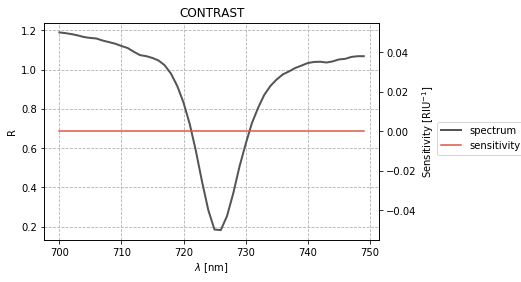

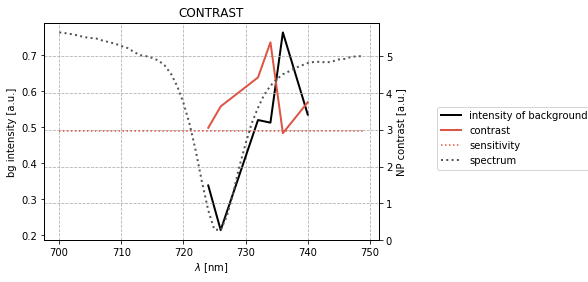

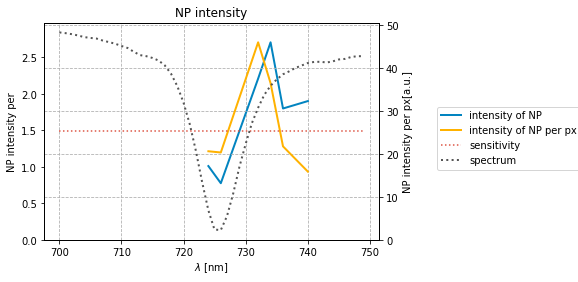

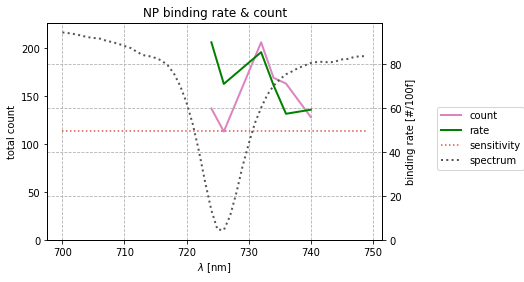

In [29]:
data, folder = data_about_master('Q4')
plot_spectrum(data, folder)
plot_contrast(data, folder)
plot_npi(data, folder)
plot_rate(data, folder)

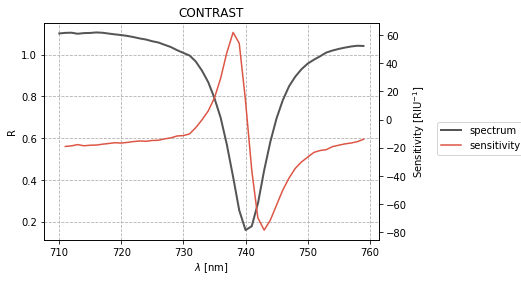

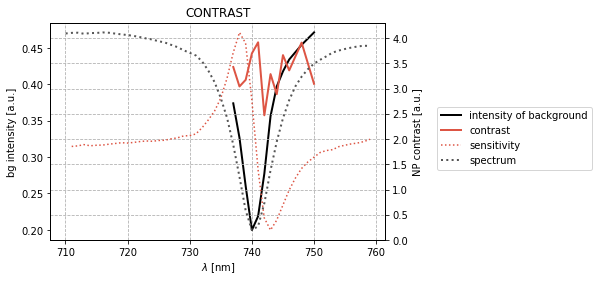

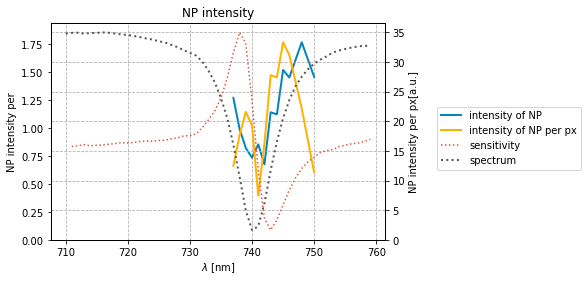

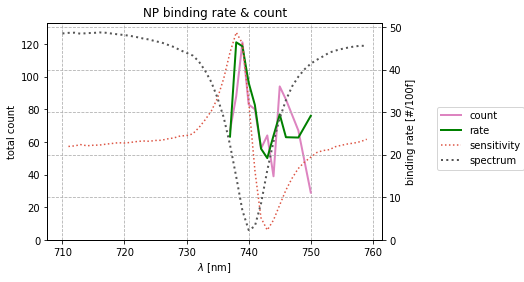

In [30]:
data, folder = data_about_master('L3')
plot_spectrum(data, folder)
plot_contrast(data, folder)
plot_npi(data, folder)
plot_rate(data, folder)

# 650

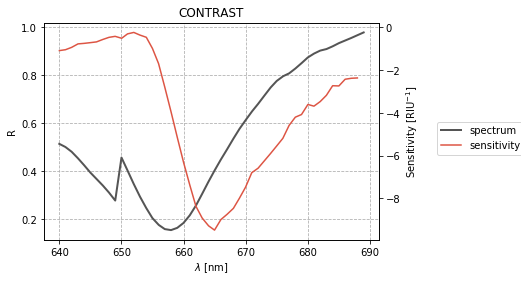

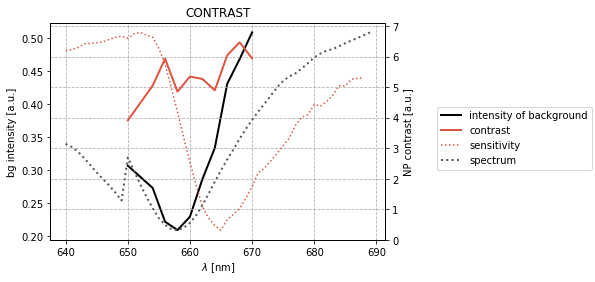

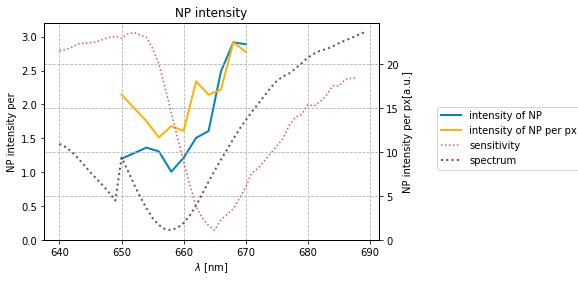

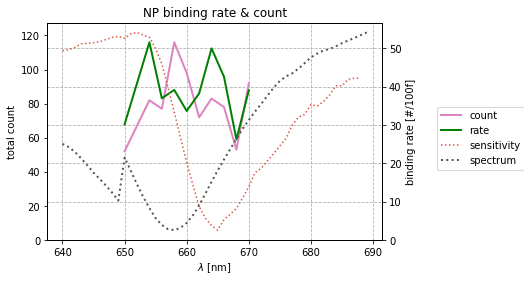

In [31]:
data, folder = data_about_master('K5')
plot_spectrum(data, folder)
plot_contrast(data, folder)
plot_npi(data, folder)
plot_rate(data, folder)

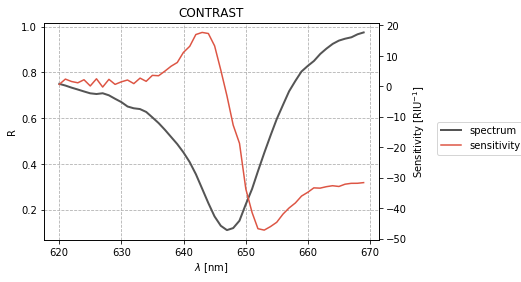

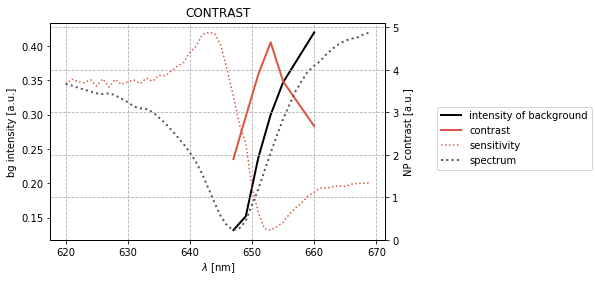

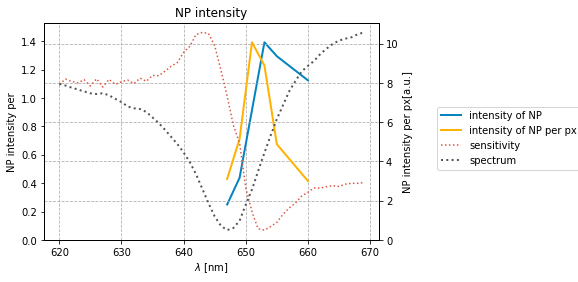

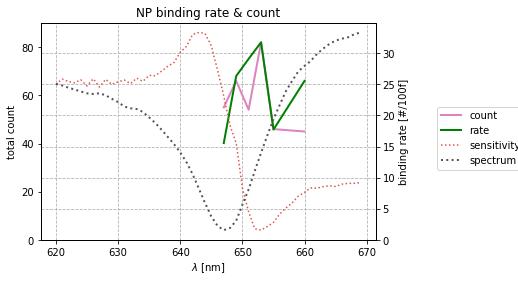

In [32]:
data, folder = data_about_master('K4')
plot_spectrum(data, folder)
plot_contrast(data, folder)
plot_npi(data, folder)
plot_rate(data, folder)

# 600

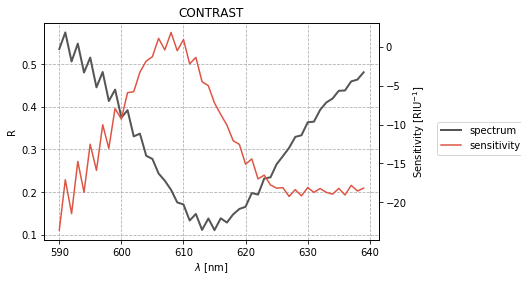

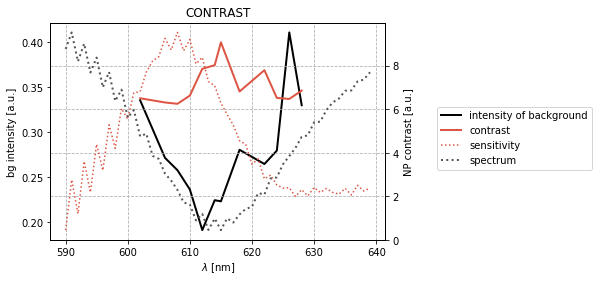

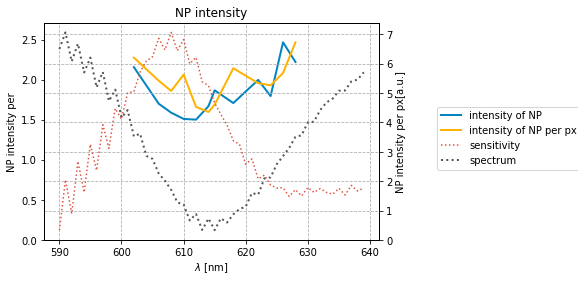

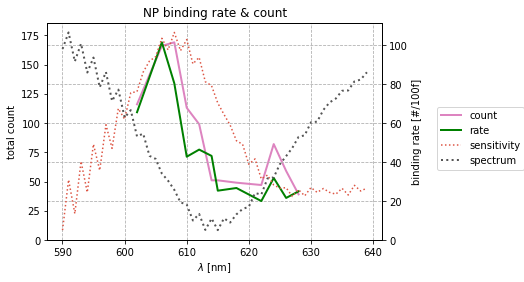

In [33]:
data, folder = data_about_master('P3')
plot_spectrum(data, folder)
plot_contrast(data, folder)
plot_npi(data, folder)
plot_rate(data, folder)

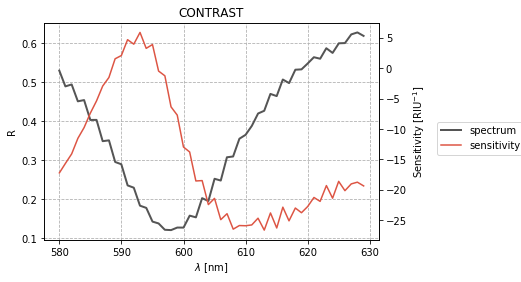

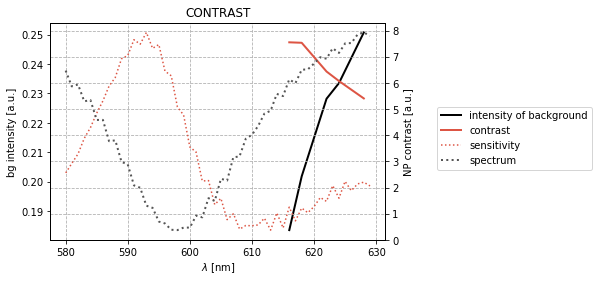

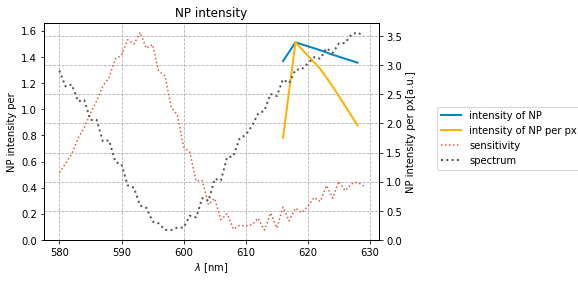

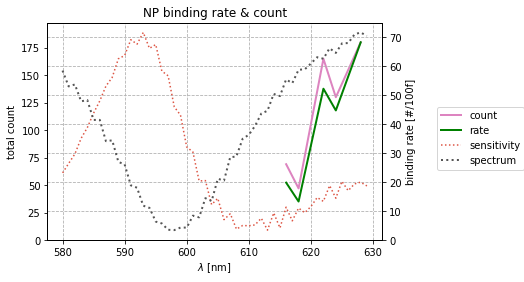

In [34]:
data, folder = data_about_master('M5')
plot_spectrum(data, folder)
plot_contrast(data, folder)
plot_npi(data, folder)
plot_rate(data, folder)